In [1]:
%pip install pandas 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 37.8 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 38.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pandas]2m3/4 [pandas]
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

In [4]:
kepler_df = pd.read_csv("cumulative_2025.10.04_14.02.58.csv", low_memory=False)
tess_df = pd.read_csv("TOI_2025.10.04_14.33.22.csv", low_memory=False)

print(f"✅ Kepler shape: {kepler_df.shape}")
print(f"✅ TESS shape: {tess_df.shape}\n")

✅ Kepler shape: (9564, 49)
✅ TESS shape: (7703, 65)



In [5]:
kepler_cols = {
    'kepid': 'id',
    'koi_disposition': 'disposition',
    'koi_period': 'orbital_period_days',
    'koi_duration': 'transit_duration_hours',
    'koi_depth': 'transit_depth_ppm',
    'koi_prad': 'planet_radius_re',
    'koi_teq': 'equilibrium_temp_k',
    'koi_insol': 'insolation_flux_earth',
    'koi_model_snr': 'model_snr',
    'koi_steff': 'stellar_teff_k',
    'koi_srad': 'stellar_radius_re',
    'koi_kepmag': 'apparent_mag',
    'ra': 'ra',
    'dec': 'dec'
}

kepler_df = kepler_df[list(kepler_cols.keys())].rename(columns=kepler_cols)
kepler_df["mission"] = "Kepler"

In [19]:
# Filter Kepler data - exclude CANDIDATE, only keep CONFIRMED and FALSE POSITIVE
print("Kepler disposition values before filtering:")
print(kepler_df["disposition"].value_counts())

kepler_df = kepler_df[kepler_df["disposition"].isin(["CONFIRMED", "FALSE POSITIVE"])]
kepler_df["label"] = kepler_df["disposition"].map({"CONFIRMED": 1, "FALSE POSITIVE": 0})

print(f"\nKepler data after filtering (excluding candidates): {len(kepler_df)} samples")
print("Kepler disposition breakdown:")
print(kepler_df["disposition"].value_counts())

Kepler disposition values before filtering:
disposition
FALSE POSITIVE    4839
CONFIRMED         2746
Name: count, dtype: int64

Kepler data after filtering (excluding candidates): 7585 samples
Kepler disposition breakdown:
disposition
FALSE POSITIVE    4839
CONFIRMED         2746
Name: count, dtype: int64


In [15]:
# Re-read TESS data and process it correctly
tess_df = pd.read_csv("TOI_2025.10.04_14.33.22.csv", low_memory=False)

tess_cols = {
    'toi': 'id',
    'tfopwg_disp': 'disposition',
    'pl_orbper': 'orbital_period_days',
    'pl_trandurh': 'transit_duration_hours',
    'pl_trandep': 'transit_depth_ppm',
    'pl_rade': 'planet_radius_re',
    'pl_eqt': 'equilibrium_temp_k',
    'pl_insol': 'insolation_flux_earth',
    'st_tmag': 'apparent_mag',
    'st_teff': 'stellar_teff_k',
    'st_rad': 'stellar_radius_re',
    'ra': 'ra',
    'dec': 'dec'
}

# Check which columns exist and select only those
available_cols = [col for col in tess_cols.keys() if col in tess_df.columns]
print(f"Available TESS columns: {available_cols}")

tess_df = tess_df[available_cols].rename(columns=tess_cols)
tess_df["mission"] = "TESS"

print(f"TESS data shape after column selection: {tess_df.shape}")
print(f"TESS disposition values: {tess_df['disposition'].value_counts()}")

Available TESS columns: ['toi', 'tfopwg_disp', 'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_eqt', 'pl_insol', 'st_tmag', 'st_teff', 'st_rad', 'ra', 'dec']
TESS data shape after column selection: (7703, 14)
TESS disposition values: disposition
PC     4679
FP     1197
CP      684
KP      583
APC     462
FA       98
Name: count, dtype: int64


In [21]:
# Re-read TESS data fresh to avoid previous processing issues
tess_df = pd.read_csv("TOI_2025.10.04_14.33.22.csv", low_memory=False)

# Apply column selection and renaming again
tess_cols = {
    'toi': 'id',
    'tfopwg_disp': 'disposition',
    'pl_orbper': 'orbital_period_days',
    'pl_trandurh': 'transit_duration_hours',
    'pl_trandep': 'transit_depth_ppm',
    'pl_rade': 'planet_radius_re',
    'pl_eqt': 'equilibrium_temp_k',
    'pl_insol': 'insolation_flux_earth',
    'st_tmag': 'apparent_mag',
    'st_teff': 'stellar_teff_k',
    'st_rad': 'stellar_radius_re',
    'ra': 'ra',
    'dec': 'dec'
}

available_cols = [col for col in tess_cols.keys() if col in tess_df.columns]
tess_df = tess_df[available_cols].rename(columns=tess_cols)
tess_df["mission"] = "TESS"

# Map TESS disposition codes to standard labels
# CP = Confirmed Planet, KP = Known Planet -> CONFIRMED (1)
# FP = False Positive, FA = False Alarm, APC = Astrophysical False Positive -> FALSE POSITIVE (0)
# PC = Planet Candidate -> EXCLUDE (we're ignoring candidates)

print(f"TESS data before filtering: {len(tess_df)} samples")
print("Original disposition values:")
print(tess_df['disposition'].value_counts())

tess_disposition_mapping = {
    'CP': 'CONFIRMED',     # Confirmed Planet
    'KP': 'CONFIRMED',     # Known Planet  
    'FP': 'FALSE POSITIVE', # False Positive
    'FA': 'FALSE POSITIVE', # False Alarm
    'APC': 'FALSE POSITIVE' # Astrophysical False Positive Candidate
    # Note: PC (Planet Candidate) is intentionally excluded from mapping
}

# Map the disposition values (PC will become NaN and be filtered out)
tess_df['disposition'] = tess_df['disposition'].map(tess_disposition_mapping)

print(f"\nAfter mapping (PC becomes NaN and is excluded):")
print(tess_df['disposition'].value_counts())

# Filter out NaN values (which were the PC candidates) and keep only mapped values
tess_df = tess_df[tess_df["disposition"].notna()]
tess_df["label"] = tess_df["disposition"].map({"CONFIRMED": 1, "FALSE POSITIVE": 0})

print(f"\nTESS data after filtering (excluding {4679} PC candidates): {len(tess_df)} samples")
print("Final TESS disposition breakdown:")
print(tess_df['disposition'].value_counts())

TESS data before filtering: 7703 samples
Original disposition values:
disposition
PC     4679
FP     1197
CP      684
KP      583
APC     462
FA       98
Name: count, dtype: int64

After mapping (PC becomes NaN and is excluded):
disposition
FALSE POSITIVE    1757
CONFIRMED         1267
Name: count, dtype: int64

TESS data after filtering (excluding 4679 PC candidates): 3024 samples
Final TESS disposition breakdown:
disposition
FALSE POSITIVE    1757
CONFIRMED         1267
Name: count, dtype: int64


In [22]:
common_cols = [
    "id", "mission", "disposition", "label",
    "orbital_period_days", "transit_duration_hours", "transit_depth_ppm",
    "planet_radius_re", "equilibrium_temp_k", "insolation_flux_earth",
    "stellar_teff_k", "stellar_radius_re", "apparent_mag", "ra", "dec"
]

kepler_aligned = kepler_df[common_cols]
tess_aligned = tess_df[common_cols]

combined_df = pd.concat([kepler_aligned, tess_aligned], ignore_index=True)

print(f"✅ Combined dataset shape: {combined_df.shape}")
print("Mission breakdown:\n", combined_df["mission"].value_counts(), "\n")

combined_df.head()

✅ Combined dataset shape: (10609, 15)
Mission breakdown:
 mission
Kepler    7585
TESS      3024
Name: count, dtype: int64 



,id,mission,disposition,label,orbital_period_days,transit_duration_hours,transit_depth_ppm,planet_radius_re,equilibrium_temp_k,insolation_flux_earth,stellar_teff_k,stellar_radius_re,apparent_mag,ra,dec
0,10797460.0,Kepler,CONFIRMED,1,9.488036,2.95750,615.8,2.26,793.0,93.59,5455.0,0.927,15.347,291.93423,48.141651
1,10797460.0,Kepler,CONFIRMED,1,54.418383,4.50700,874.8,2.83,443.0,9.11,5455.0,0.927,15.347,291.93423,48.141651
2,10848459.0,Kepler,FALSE POSITIVE,0,1.736952,2.40641,8079.2,33.46,1395.0,891.96,5805.0,0.791,15.597,285.53461,48.285210
3,10854555.0,Kepler,CONFIRMED,1,2.525592,1.65450,603.3,2.75,1406.0,926.16,6031.0,1.046,15.509,288.75488,48.226200
4,10872983.0,Kepler,CONFIRMED,1,11.094321,4.59450,1517.5,3.90,835.0,114.81,6046.0,0.972,15.714,296.28613,48.224670


In [24]:
combined_df.to_csv("combined_kepler_tess_exoplanets.csv", index=False)
print("📦 Saved as combined_kepler_tess_exoplanets.csv")

📦 Saved as combined_kepler_tess_exoplanets.csv


In [23]:
# Count and display the number of confirmed vs false positive exoplanets
print("Disposition breakdown:")
disposition_counts = combined_df["disposition"].value_counts()
print(disposition_counts)
print(f"\nConfirmed: {disposition_counts.get('CONFIRMED', 0)}")
print(f"False Positives: {disposition_counts.get('FALSE POSITIVE', 0)}")

# Calculate percentage
total = disposition_counts.sum()
print(f"\nConfirmed: {disposition_counts.get('CONFIRMED', 0) / total:.1%}")
print(f"False Positives: {disposition_counts.get('FALSE POSITIVE', 0) / total:.1%}")



Disposition breakdown:
disposition
FALSE POSITIVE    6596
CONFIRMED         4013
Name: count, dtype: int64

Confirmed: 4013
False Positives: 6596

Confirmed: 37.8%
False Positives: 62.2%


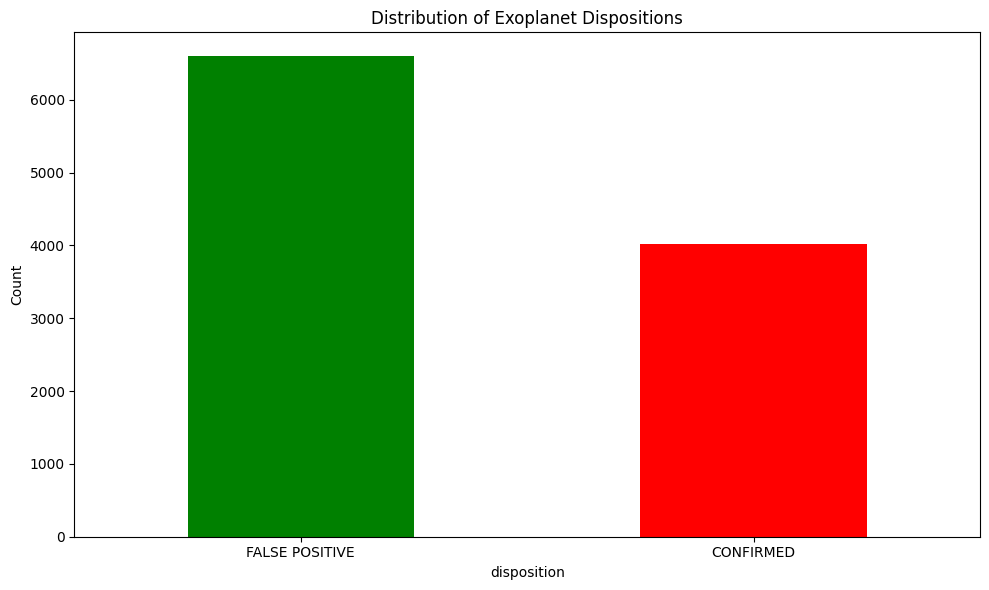

In [27]:
# Visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
combined_df["disposition"].value_counts().plot(kind="bar", color=["green", "red"])
plt.title("Distribution of Exoplanet Dispositions")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
%pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 32.2 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 35.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 40.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.
